#### Problem Statement:

- Understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients.

- This can be used to place ads of relevent products in the related search pages so that the clicks can increase and make more profits with less cost in ads.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [163]:
ad_data = pd.read_csv('train_1.csv')
raw_data = ad_data.copy()

campaign_eng = pd.DataFrame()
with open('Exog_Campaign_eng', 'rt') as f:
    content = f.read()
campaign_eng[content.split('\n')[0]]=content.split('\n')[1:-1]
campaign_eng['Date'] =  ad_data.columns[1:]
campaign_eng['Date'] = pd.to_datetime(campaign_eng['Date'])
campaign_eng['Exog']= campaign_eng['Exog'].astype('int')
campaign_eng.set_index('Date',inplace=True)

In [231]:
ad_data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [233]:
ad_data.shape

(145063, 551)

## EDA

#### Dealing with Null values

- Drop pages which are having all nulls.
- For some pages there are nulls at starting and ending as the page is started after 2015-07-01 and ended before 2016-12-31. These nulls are filled with 0.
- Droped the pages which are having more than 10% of the values are null.
- Other null values which are in between the values are filled with linear interpolate.

In [5]:
ad_data['no_of_null'] = ad_data.isna().sum(axis=1)
ad_data.drop((ad_data[ad_data['no_of_null']==550]).index,inplace=True)

In [7]:
ad_data.reset_index(drop=True,inplace=True)
null = ad_data.iloc[:,1:-1].isna()
ad_data['seq_len'] = 0
ad_data['start_date_index'] = 0
ad_data['end_date_index'] = 0

for i in range(len(ad_data)):
    k=null.iloc[i,:].reset_index()
    l=k[k[i]==False].index
    s =550 - (l[-1] - l[0] + 1 )
    ad_data.loc[i,'seq_len'] = s
    ad_data.loc[i,'start_date_index'] = l[0]
    ad_data.loc[i,'end_date_index'] = l[-1]
    
ad_data['diff'] = ad_data['no_of_null']- ad_data['seq_len']

In [8]:
def extract_language(text):
    """
    Extracts the language from the given Page string
    
    Parameters
    ----------
    text: string from which language need to be extracted

    Returns
    -------
    string 

    Example
    -------
    >>>extract_language('2NE1_zh.wikipedia.org_all-access_spider')
    'zh'
    """
    try:
        found = re.search('_(..?).wikipedia', text).group(1)
    except AttributeError:
        # AAA, ZZZ not found in the original string
        found = '' # apply your error handling
    return found

ad_data['language'] = ad_data['Page'].apply(lambda x: extract_language(x))
ad_data['access_origin']=ad_data['Page'].apply(lambda x: x.split('_')[-1])
ad_data['access_type']=ad_data['Page'].apply(lambda x: x.split('_')[-2])

In [9]:
ad_data.drop(ad_data[(ad_data['no_of_null']>500)&(ad_data['diff']>7)].index,inplace=True)
ad_data.drop(ad_data[((ad_data['no_of_null']>400)&(ad_data['diff']>15))].index,inplace=True)
ad_data.drop(ad_data[((ad_data['no_of_null']>300)&(ad_data['diff']>25))].index,inplace=True)
ad_data.drop(ad_data[((ad_data['no_of_null']>200)&(ad_data['diff']>35))].index,inplace=True)
ad_data.drop(ad_data[((ad_data['no_of_null']>100)&(ad_data['diff']>45))].index,inplace=True)
ad_data.drop(ad_data[((ad_data['no_of_null']>0)&(ad_data['diff']>55))].index,inplace=True)
ad_data.reset_index(drop=True,inplace=True)

In [10]:
fill_na = ad_data.loc[(ad_data['seq_len']!=ad_data['no_of_null']),:].iloc[:,1:551].interpolate(axis=1,method ='linear', limit_direction ='forward')

In [11]:
for i in fill_na.index:
    ad_data.iloc[i,1:551]= fill_na.loc[i,:]

for i in fill_na.index:
    if ad_data.loc[i,'end_date_index']!=549:
        for j in range(ad_data.loc[i,'end_date_index']+2,551):
            ad_data.iloc[i,j]=np.nan

ad_data.fillna(0,inplace=True)

- Grouping by language and average the view counts

In [12]:
d1 = dict.fromkeys(ad_data.columns[1:551], 'mean')

#https://stackoverflow.com/questions/38987
d = {**d1}
lang_data = ad_data.groupby('language').agg(d)

- Formatting the data

In [13]:
clean_data = lang_data.T.copy()
clean_data.reset_index(inplace=True)
clean_data.columns = ['Date']+list(clean_data.columns[1:])
clean_data['Date']= pd.to_datetime(clean_data['Date'])
clean_data.set_index('Date',inplace=True)


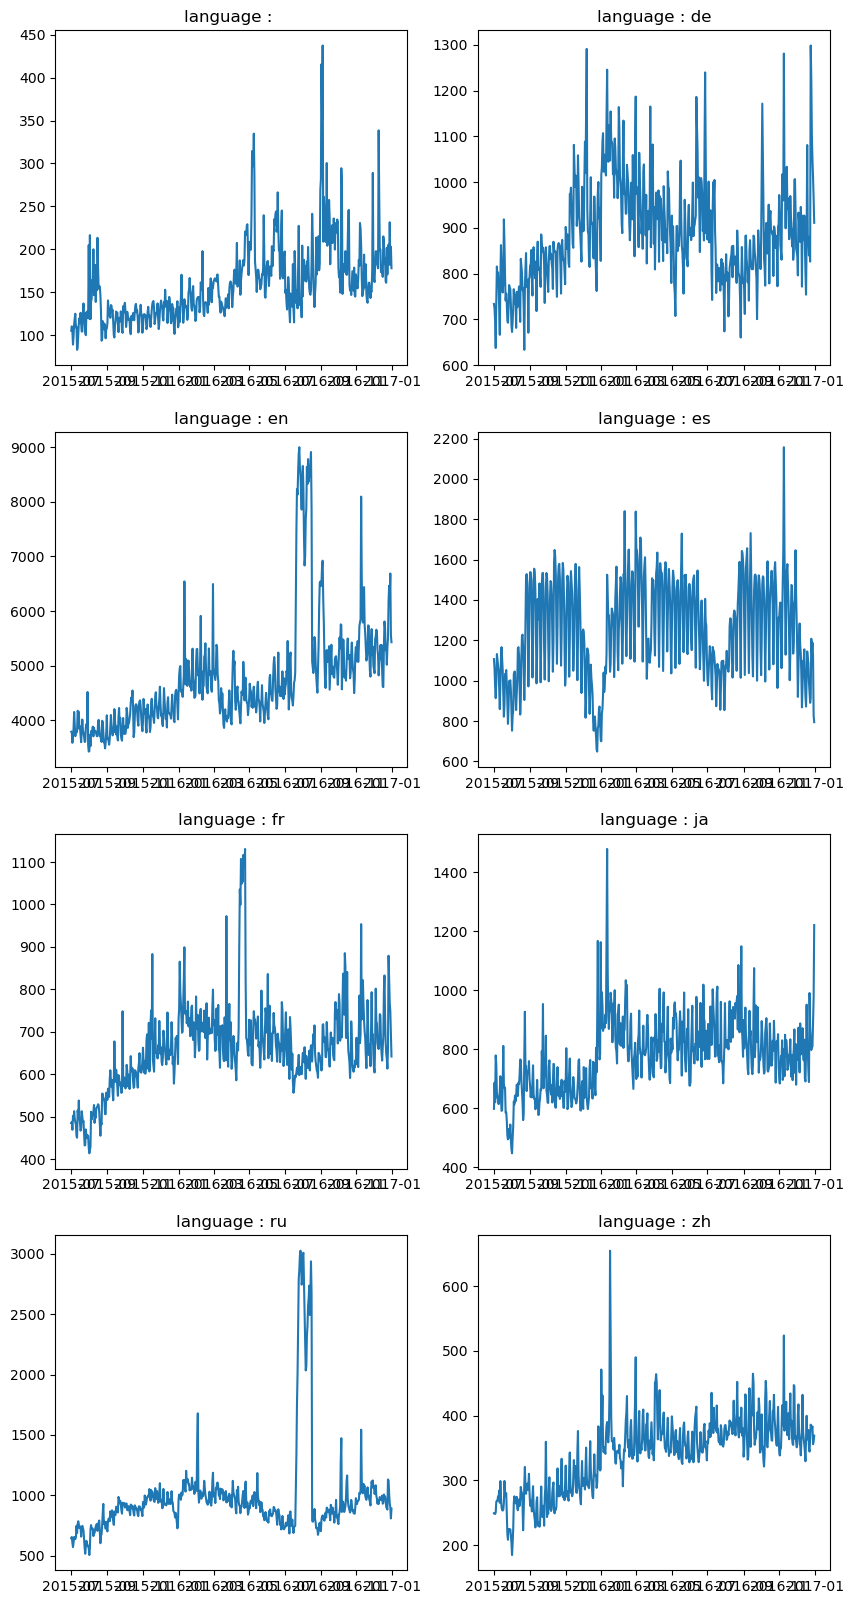

In [30]:
j=1
plt.figure(figsize=(10,20))

for i in clean_data.columns:
    plt.subplot(4,2,j)
    plt.plot(clean_data[i])
    plt.title('language : '+i)
    j+=1

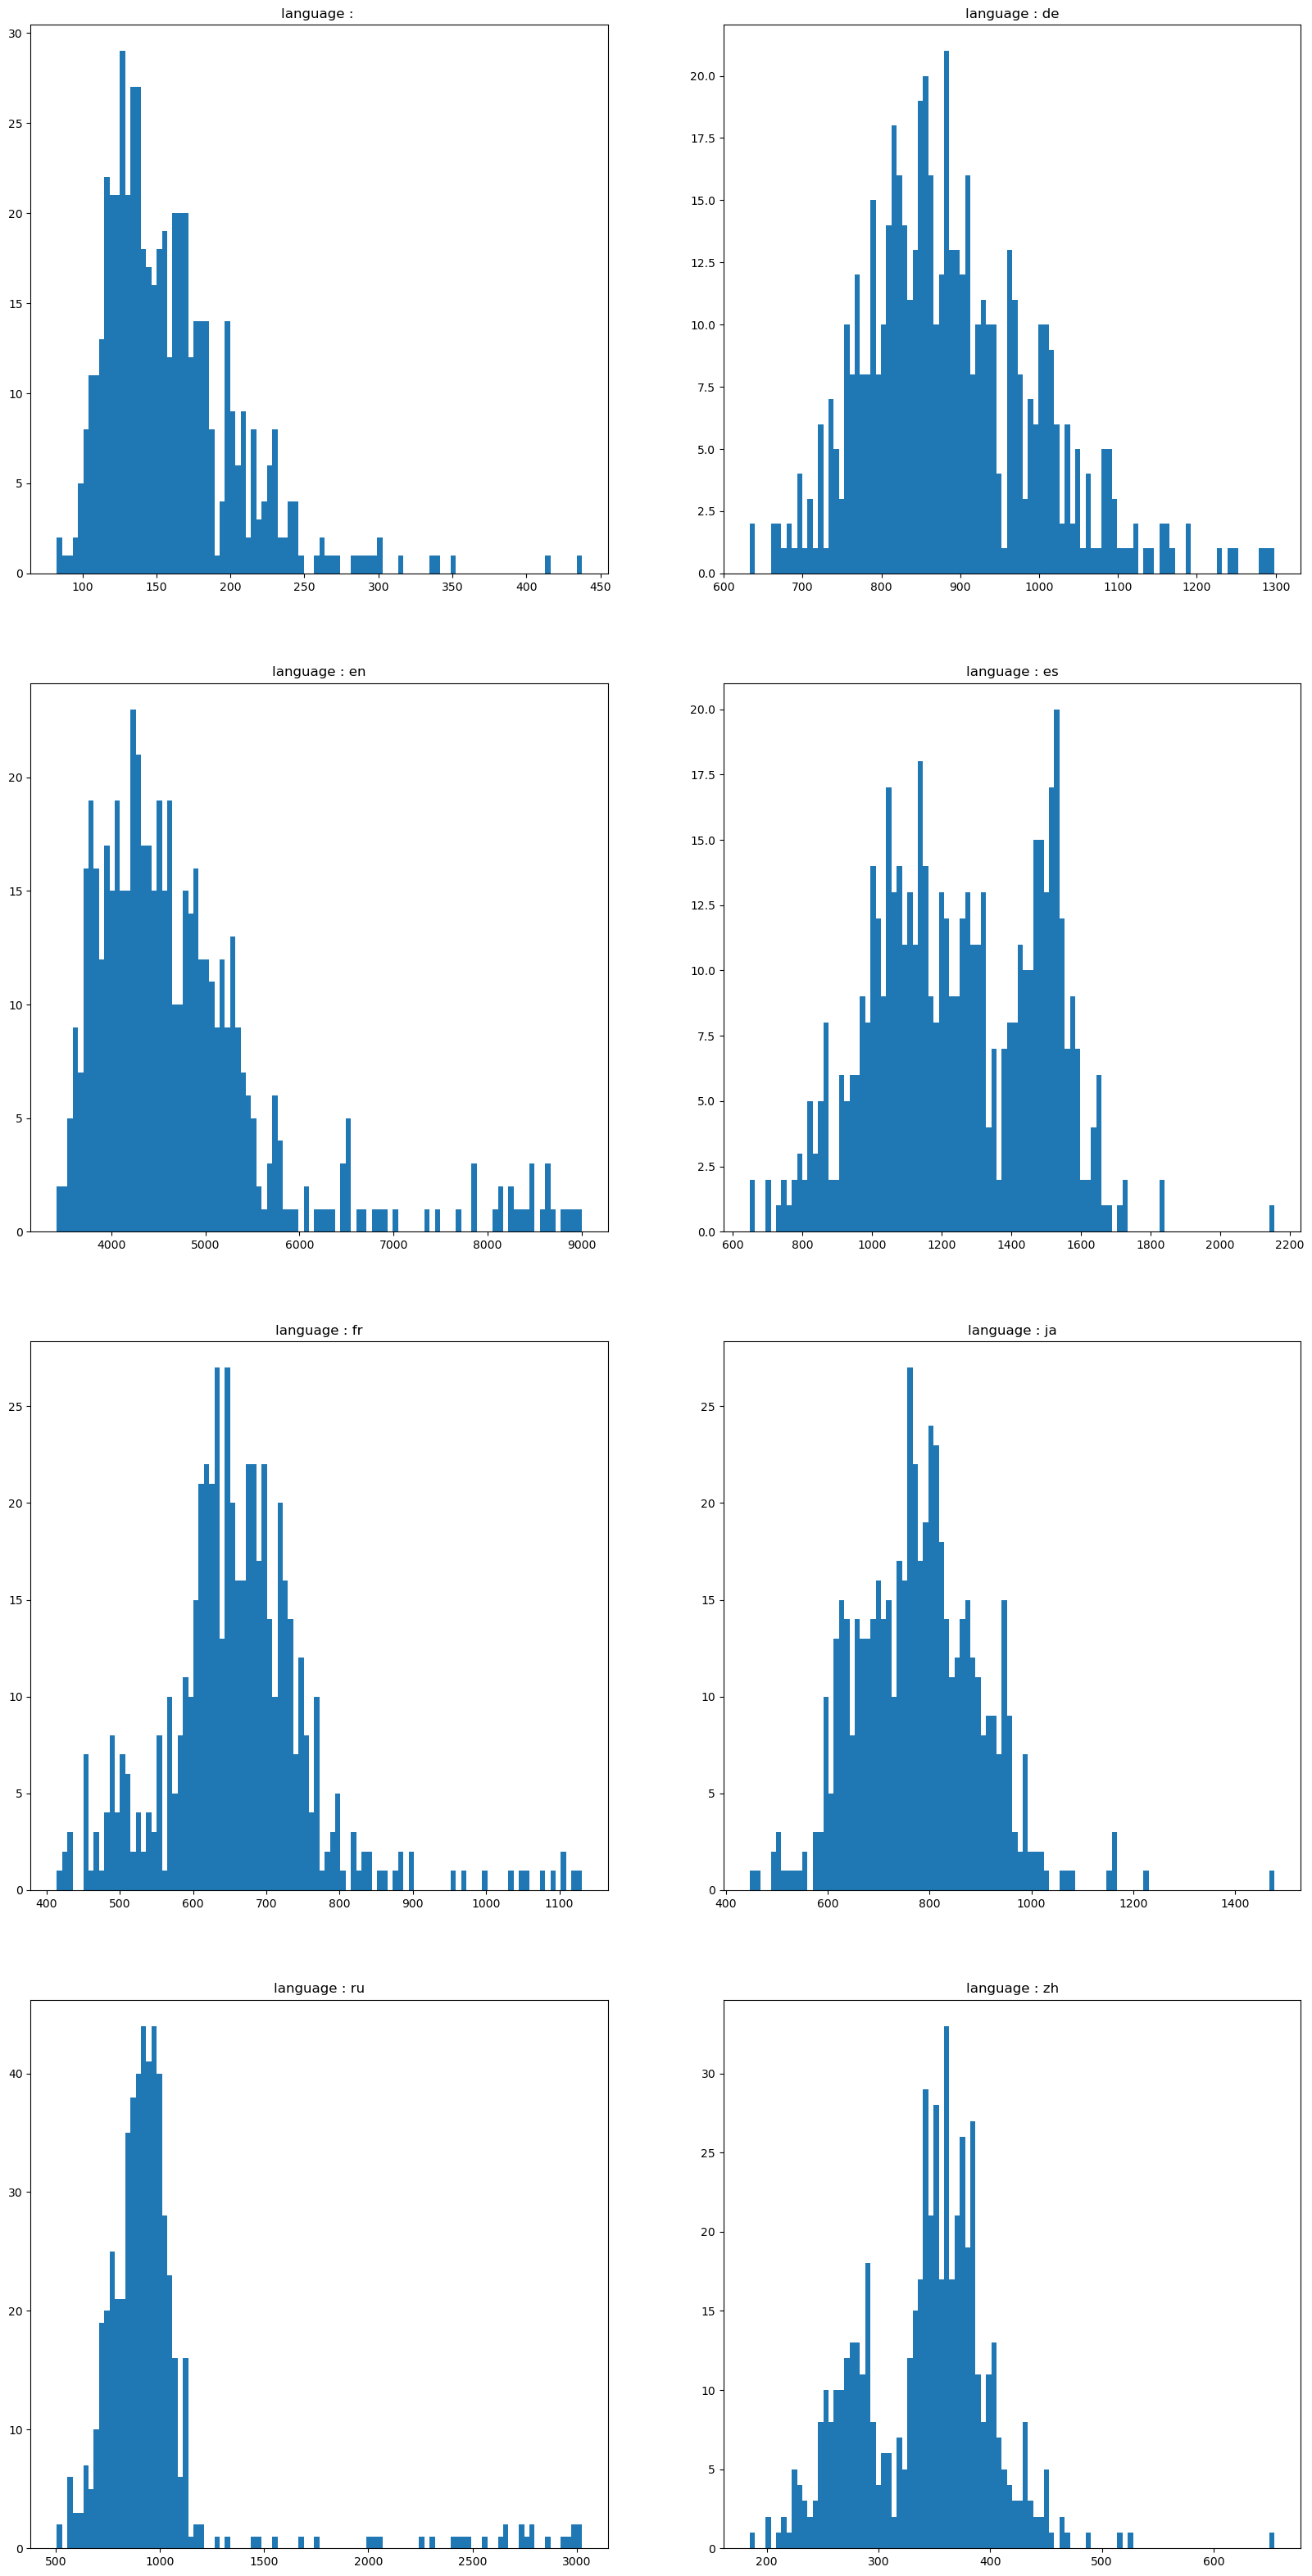

In [31]:
j=1
plt.figure(figsize=(20,40))

for i in clean_data.columns:
    plt.subplot(4,2,j)
    plt.hist(clean_data[i],bins=100)
    plt.title('language : '+i)
    j+=1

<AxesSubplot:xlabel='Date'>

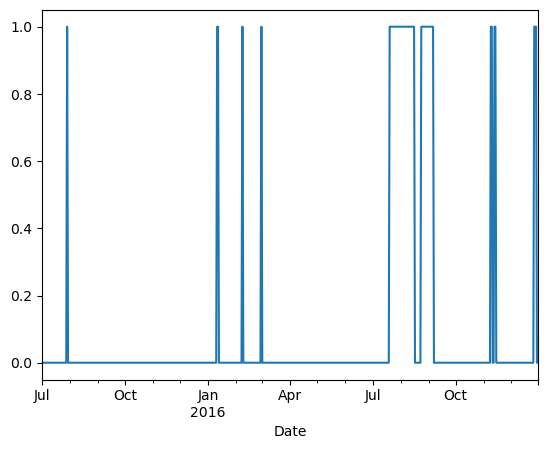

In [ ]:
campaign_eng['Exog'].plot()

In [240]:
vis_data = clean_data.reset_index().copy()
vis_data['month'] = vis_data['Date'].dt.month

<AxesSubplot:xlabel='month', ylabel='en'>

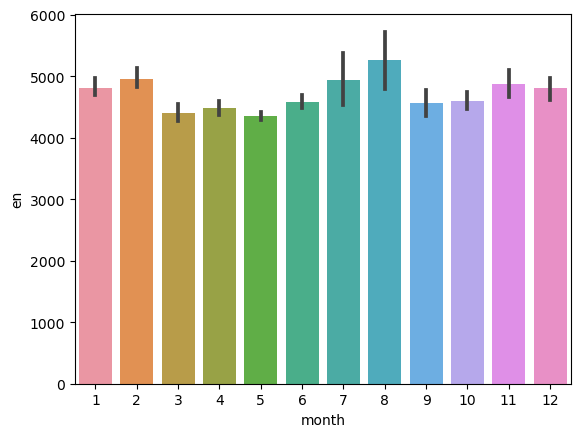

In [261]:
import seaborn as sns
sns.barplot(data=vis_data,y='en',x='month')

In [15]:
lang_de = clean_data[['de']]
lang_de.columns = ['clicks']
lang_en = clean_data[['en']]
lang_en.columns = ['clicks']
lang_es = clean_data[['es']]
lang_es.columns = ['clicks']
lang_fr = clean_data[['fr']]
lang_fr.columns = ['clicks']
lang_ja = clean_data[['ja']]
lang_ja.columns = ['clicks']
lang_zh = clean_data[['zh']]
lang_zh.columns = ['clicks']
lang_ru = clean_data[['ru']]
lang_ru.columns = ['clicks']

lst_lang_data = [{'lang_de':lang_de},{'lang_en':lang_en},{'lang_es':lang_es},
                {'lang_fr':lang_fr},{'lang_ja':lang_ja},{'lang_zh':lang_zh},{'lang_ru':lang_ru}]

==================================== lang_de ========================================


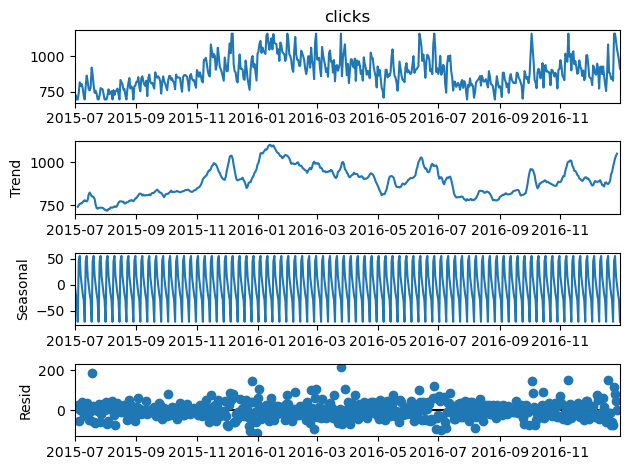

==================================== lang_en ========================================


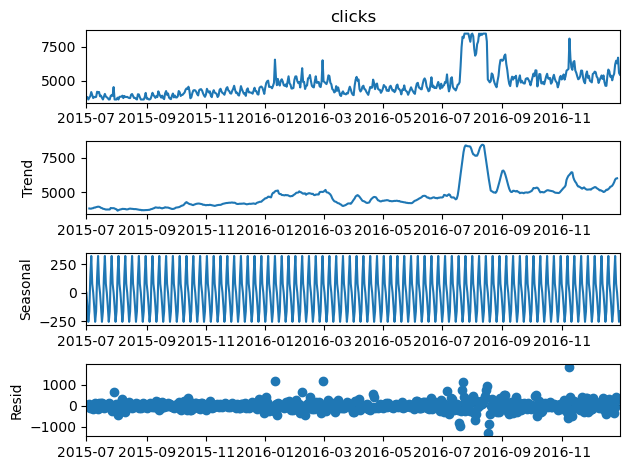

==================================== lang_es ========================================


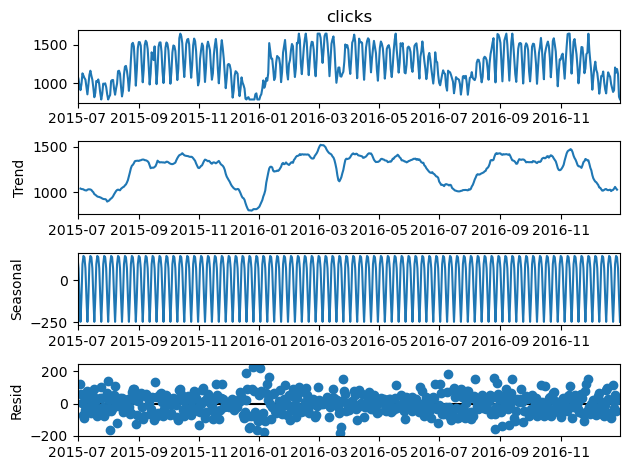

==================================== lang_fr ========================================


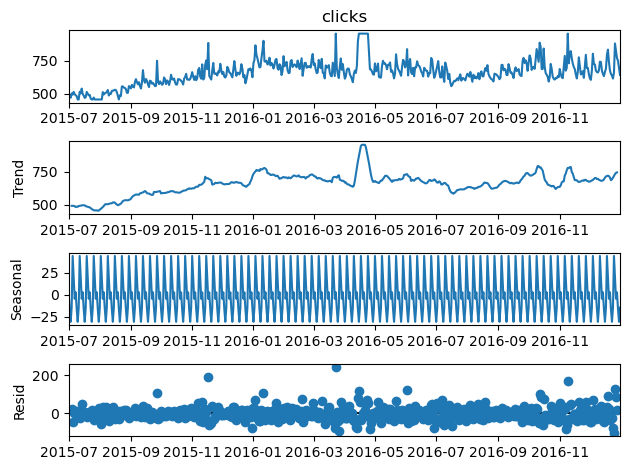

==================================== lang_ja ========================================


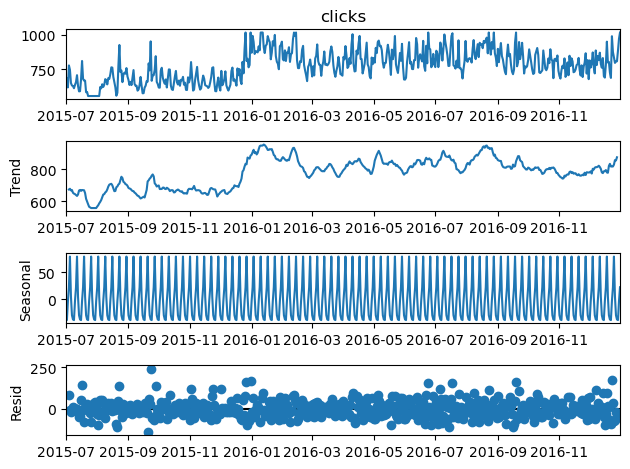

==================================== lang_zh ========================================


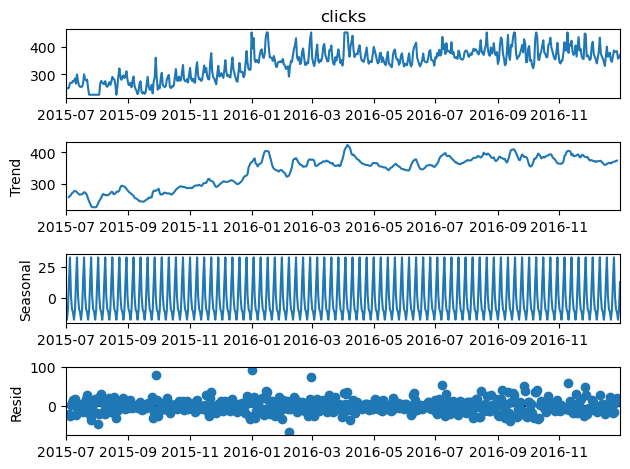

==================================== lang_ru ========================================


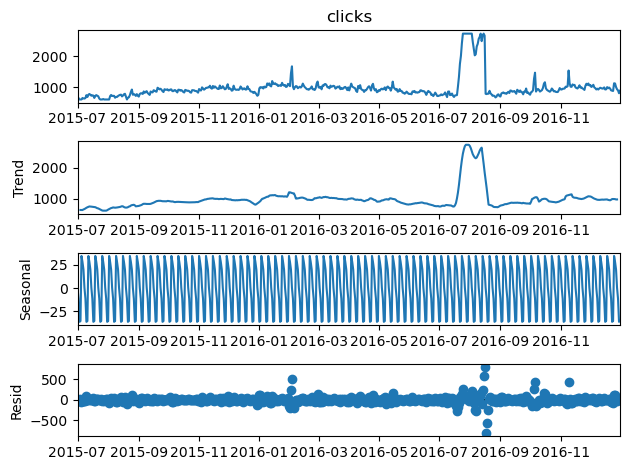

In [51]:
import statsmodels.api as sm

def decomposition(ts):
    ts.clicks.clip(upper=ts.clicks.quantile(0.98), lower=ts.clicks.quantile(0.02),inplace=True)
    model = sm.tsa.seasonal_decompose(ts.clicks, model='additive')
    plt.show(model.plot(),block=True)


for i in lst_lang_data:
    print('====================================',list(i.keys())[0],'========================================')
    decomposition(list(i.values())[0])


### Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

def stationary_test(ts, significance_level=0.05):
    pvalue =  adfuller(ts.dropna())[1]

    if pvalue<=significance_level:
        return ('Sequence is stationary')
    else:
        return ('Sequence is not stationary')

##### Checking Stationary of time series

In [28]:
for i in lst_lang_data:
    lang = list(i.keys())[0]
    print(lang,' ',stationary_test(list(i.values())[0]))

lang_de   Sequence is not stationary
lang_en   Sequence is not stationary
lang_es   Sequence is stationary
lang_fr   Sequence is stationary
lang_ja   Sequence is not stationary
lang_zh   Sequence is not stationary
lang_ru   Sequence is stationary


### Differencing

##### De-Trending

In [52]:
for i in lst_lang_data:
    lang = list(i.keys())[0]
    print('De-Trending ',lang,' ',stationary_test(list(i.values())[0].diff(1)))

De-Trending  lang_de   Sequence is stationary
De-Trending  lang_en   Sequence is stationary
De-Trending  lang_es   Sequence is stationary
De-Trending  lang_fr   Sequence is stationary
De-Trending  lang_ja   Sequence is stationary
De-Trending  lang_zh   Sequence is stationary
De-Trending  lang_ru   Sequence is stationary


##### De-Seasonalisation

In [53]:
for i in lst_lang_data:
    lang = list(i.keys())[0]
    print('De-Seasonalisation ',lang,' ',stationary_test(list(i.values())[0].diff(1).diff(7)))

De-Seasonalisation  lang_de   Sequence is stationary
De-Seasonalisation  lang_en   Sequence is stationary
De-Seasonalisation  lang_es   Sequence is stationary
De-Seasonalisation  lang_fr   Sequence is stationary
De-Seasonalisation  lang_ja   Sequence is stationary
De-Seasonalisation  lang_zh   Sequence is stationary
De-Seasonalisation  lang_ru   Sequence is stationary


## ACF and PACF plots

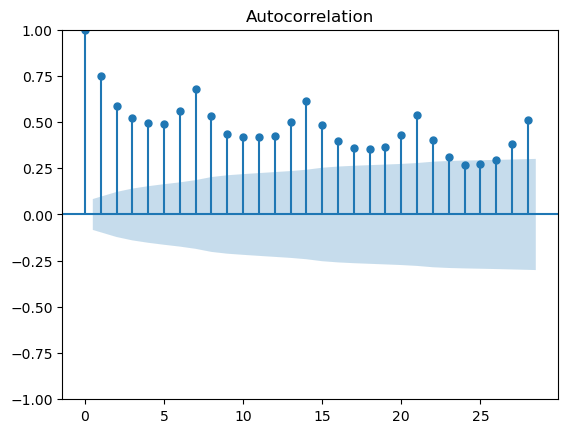

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(lang_de);

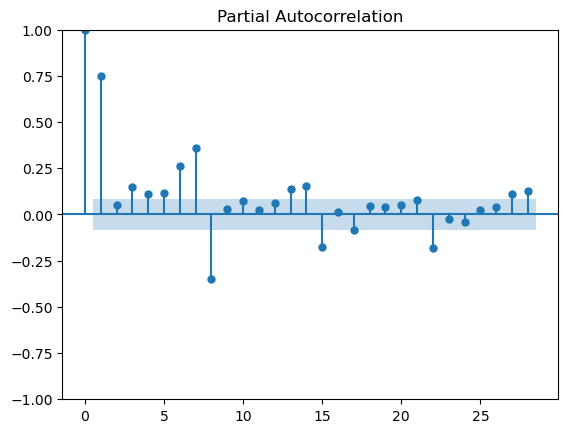

In [56]:
plot_pacf(lang_de.dropna(),method='ywm');

## ARIMA AND SARIMAX

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [129]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

In [180]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def arima_gridsearch(ts, pdq, maxiter=50, freq='D'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='D' for day. Change to suit your time series frequency
            e.g. 'M' for month, 'H' for hour, 'Y' for year. 
        
    Return:
        Returns optimised parameters
    '''
    train_ts = ts[:-14]
    test_ts = ts[-14:-7]
    ans = []
    for comb in pdq:
        try:
            mod = SARIMAX(train_ts, # this is your time series you will input
                            order=comb,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq=freq)
            output = mod.fit() 
            test_ts['pred'] = output.forecast(steps=7)
            ts_mape = round(mape(test_ts['clicks'], test_ts['pred']), 3)
            ans.append([comb, ts_mape])
        except:
            continue
    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'mape'])
    
    top = ans_df.sort_values(by=['mape'],ascending=True).iloc[0,:]

    return top




def sarimax_gridsearch(ts, pdq, pdqs, exog=None, maxiter=50, freq='D'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='D' for day. Change to suit your time series frequency
            e.g. 'M' for month, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''
    if exog is not None:
        train_exog = exog[:-14]
        test_exog = exog[-14:-7]
    else:
        train_exog=None
        test_exog=None
    train_ts = ts[:-14]
    test_ts = ts[-14:-7]
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(train_ts, # this is your time series you will input
                                order=comb,
                                seasonal_order=combs,
                                exog=train_exog,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq=freq)
                output = mod.fit() 
                test_ts['pred'] = output.forecast(steps=7,exog=test_exog)
                ts_mape = round(mape(test_ts['clicks'], test_ts['pred']), 3)
                ans.append([comb, combs, ts_mape])
            except:
                continue
    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'mape'])

    # Sort and return top 5 combinations
    top = ans_df.sort_values(by=['mape'],ascending=True).iloc[0,:]

    return top

In [ ]:

def arima(ts,pdq):
    opt_param = arima_gridsearch(ts,pdq)

    train_x = ts[:-14]
    test_x = ts[-14:-7]

    model = SARIMAX(train_x,order=opt_param.pdq)
    model = model.fit(disp=False)
    test_x['pred'] = model.forecast(steps=7)
    plt.show(test_x.plot(style='-o'),block=True)

    performance(test_x['clicks'],test_x['pred'])

def sarimax(ts,pdq,pdqs,exog=None):
    opt_param = sarimax_gridsearch(ts,pdq,pdqs,exog=exog)

    train_x = ts[:-14]
    test_x = ts[-14:-7]

    if exog is not None:
        train_exog = exog[:-14]
        test_exog = exog[-14:-7]
    else:
        train_exog=None
        test_exog=None
    
    model = SARIMAX(train_x,order=opt_param.pdq,seasonal_order=opt_param.pdqs,exog=train_exog)
    model = model.fit(disp=False)
    test_x['pred'] = model.forecast(steps=7,exog=test_exog)
    plt.show(test_x.plot(style='-o'),block=True)

    performance(test_x['clicks'],test_x['pred'])

In [182]:
import itertools
p = [4,7,14]
d = range(1, 3)
q = [3,7]
P = [1,2]
D = [1]
Q = [1,2]
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, D, Q))]

==================================== ARIMA lang_de =======================================


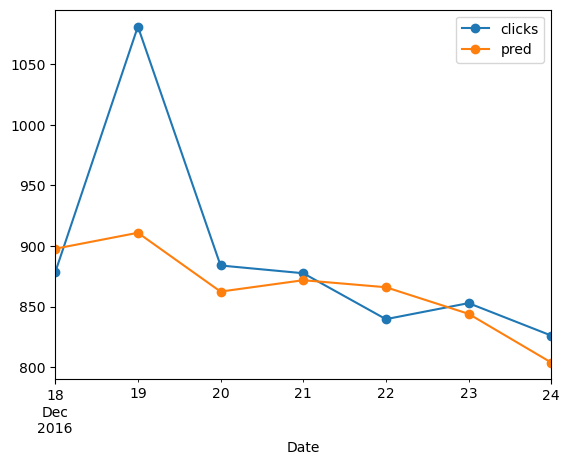

MAE : 39.172
RMSE : 66.623
MAPE: 0.04
==================================== ARIMA lang_en =======================================


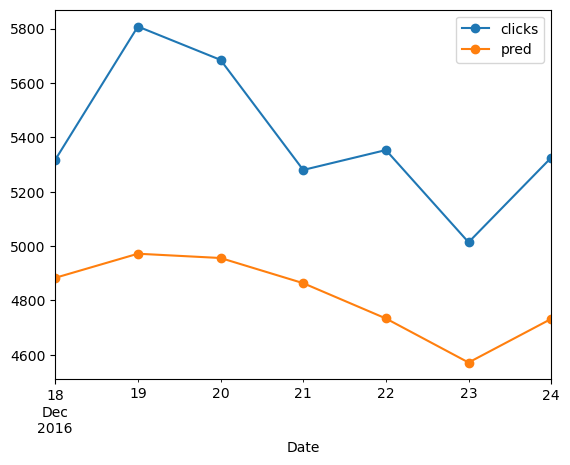

MAE : 581.614
RMSE : 600.506
MAPE: 0.107
==================================== ARIMA lang_es =======================================


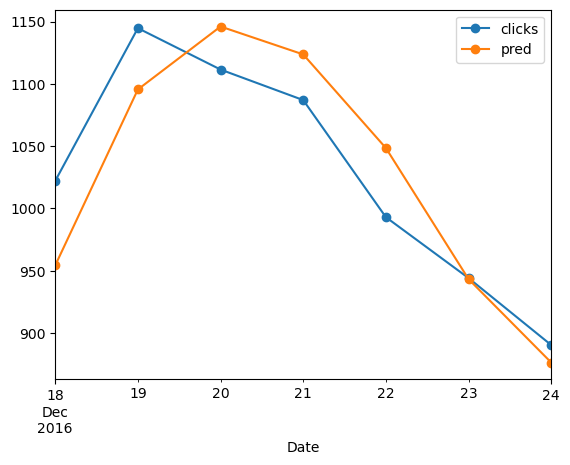

MAE : 36.966
RMSE : 42.85
MAPE: 0.035
==================================== ARIMA lang_fr =======================================


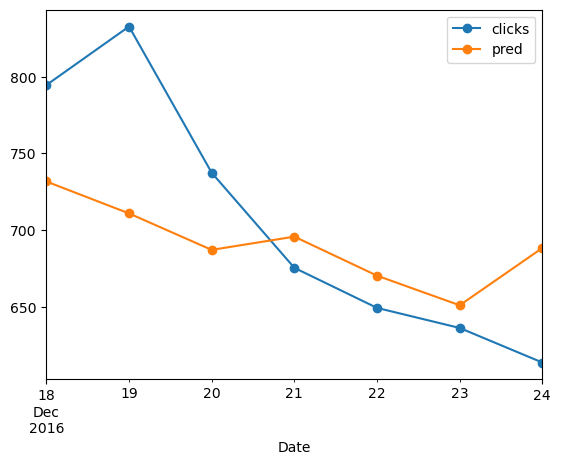

MAE : 52.302
RMSE : 63.272
MAPE: 0.072
==================================== ARIMA lang_ja =======================================


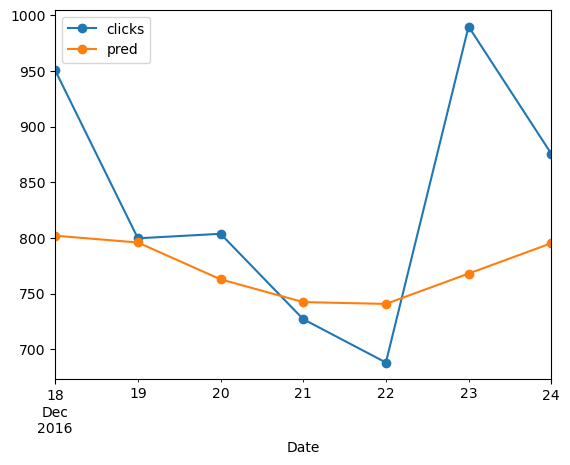

MAE : 80.488
RMSE : 108.517
MAPE: 0.089
==================================== ARIMA lang_zh =======================================


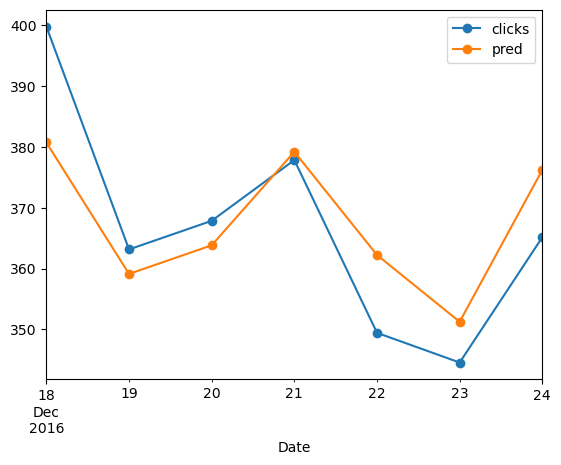

MAE : 8.433
RMSE : 10.203
MAPE: 0.023
==================================== ARIMA lang_ru =======================================


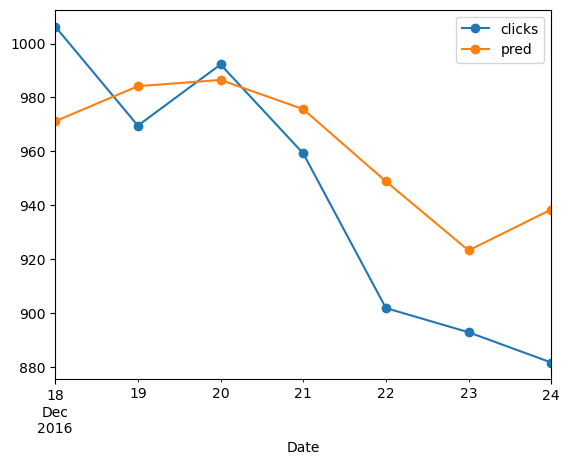

MAE : 29.43
RMSE : 34.016
MAPE: 0.032


In [262]:
for i in lst_lang_data:
    print('==================================== ARIMA',list(i.keys())[0],'=======================================')
    arima(list(i.values())[0],pdq)

====================================Sarimax lang_de =======================================


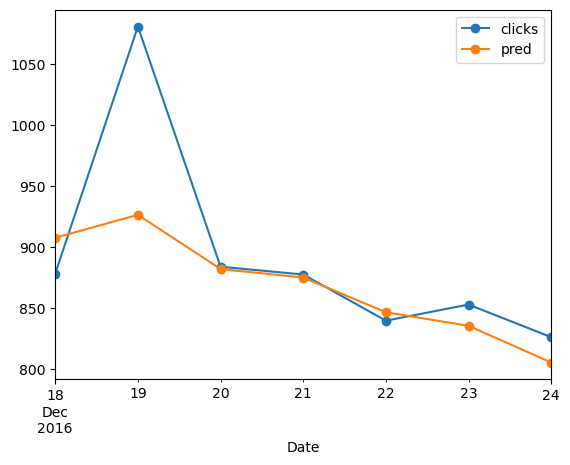

MAE : 33.345
RMSE : 60.387
MAPE: 0.034
====================================Sarimax lang_en =======================================


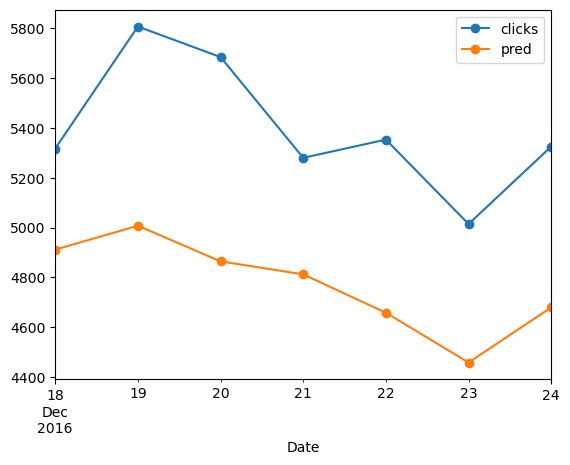

MAE : 627.973
RMSE : 645.008
MAPE: 0.116
====================================Sarimax lang_es =======================================


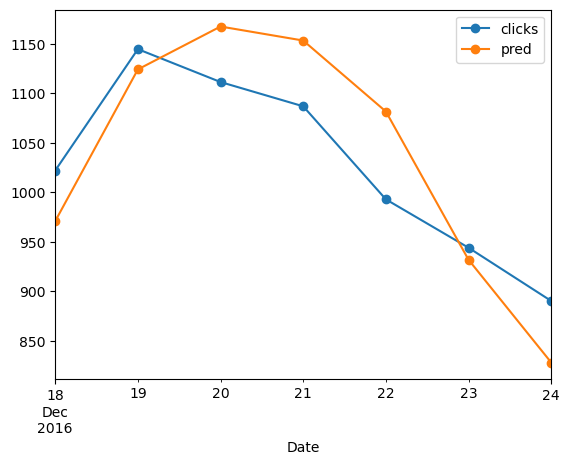

MAE : 51.04
RMSE : 56.686
MAPE: 0.05
====================================Sarimax lang_fr =======================================


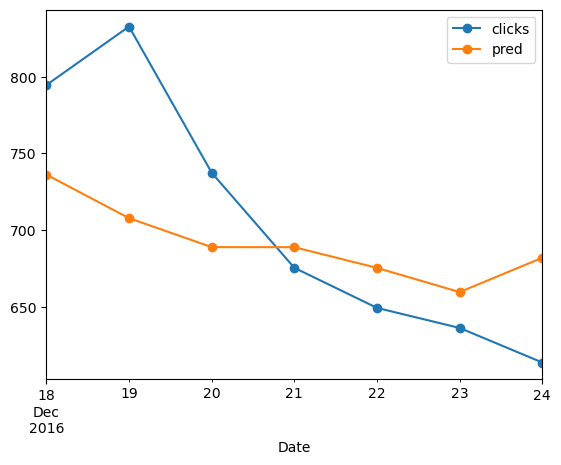

MAE : 51.905
RMSE : 62.666
MAPE: 0.071
====================================Sarimax lang_ja =======================================


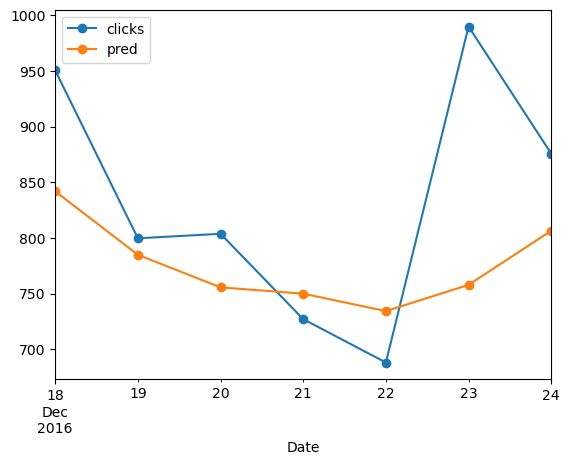

MAE : 77.413
RMSE : 103.935
MAPE: 0.086
====================================Sarimax lang_zh =======================================


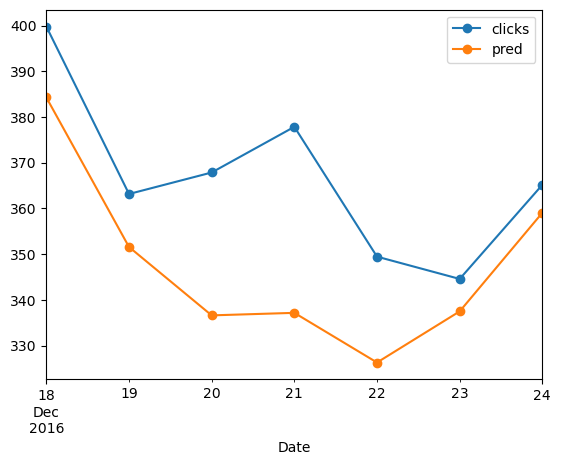

MAE : 19.353
RMSE : 22.787
MAPE: 0.052
====================================Sarimax lang_ru =======================================


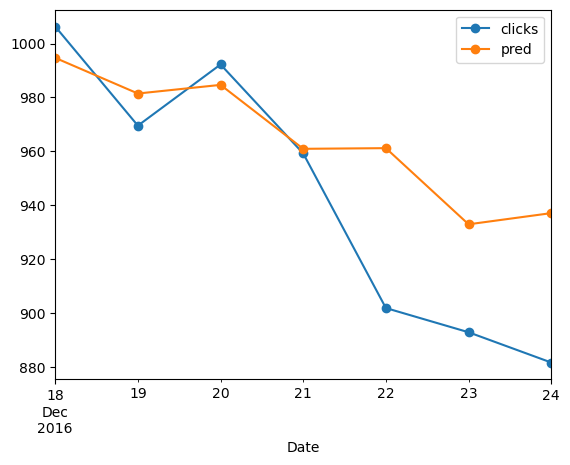

MAE : 26.797
RMSE : 34.902
MAPE: 0.03


In [184]:
for i in lst_lang_data:
    print('====================================Sarimax',list(i.keys())[0],'=======================================')
    sarimax(list(i.values())[0],pdq,pdqs,exog=campaign_eng['Exog'])

## Facebook prophet

In [ ]:
from prophet import Prophet

def fb_prophet(ts):
    p_data = ts.copy()
    p_data.reset_index(inplace=True)
    p_data.columns = ['ds','y']

    m= Prophet()
    m.fit(p_data[:-14])
    future = m.make_future_dataframe(periods=7,freq='D',include_history=False)
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    plt.plot(p_data['y'][-14:-7].values)
    plt.plot(forecast['yhat'].values)
    plt.show(block=True)

    performance(p_data['y'][-14:-7],forecast['yhat'])


==================================== Prophet lang_de =======================================


17:21:51 - cmdstanpy - INFO - Chain [1] start processing
17:21:52 - cmdstanpy - INFO - Chain [1] done processing


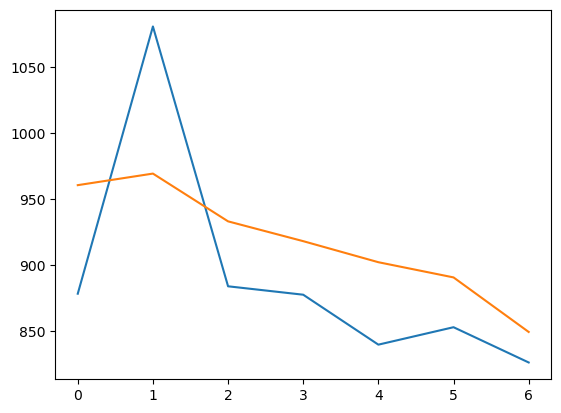

17:21:52 - cmdstanpy - INFO - Chain [1] start processing


MAE : 58.179
RMSE : 64.564
MAPE: 0.064
==================================== Prophet lang_en =======================================


17:21:52 - cmdstanpy - INFO - Chain [1] done processing


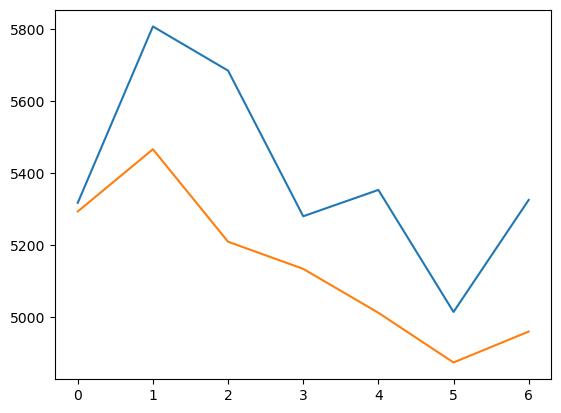

17:21:53 - cmdstanpy - INFO - Chain [1] start processing
17:21:53 - cmdstanpy - INFO - Chain [1] done processing


MAE : 262.265
RMSE : 301.299
MAPE: 0.048
==================================== Prophet lang_es =======================================


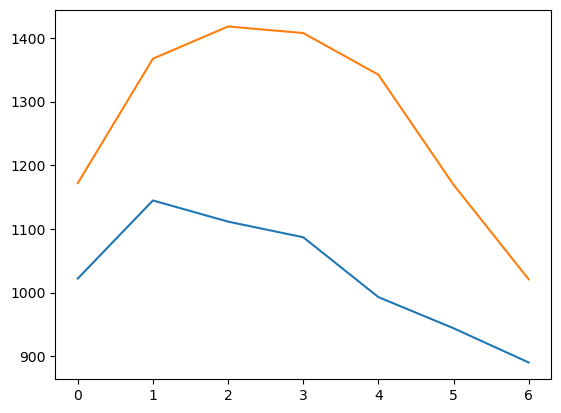

17:21:54 - cmdstanpy - INFO - Chain [1] start processing


MAE : 243.592
RMSE : 256.0
MAPE: 0.236
==================================== Prophet lang_fr =======================================


17:21:54 - cmdstanpy - INFO - Chain [1] done processing


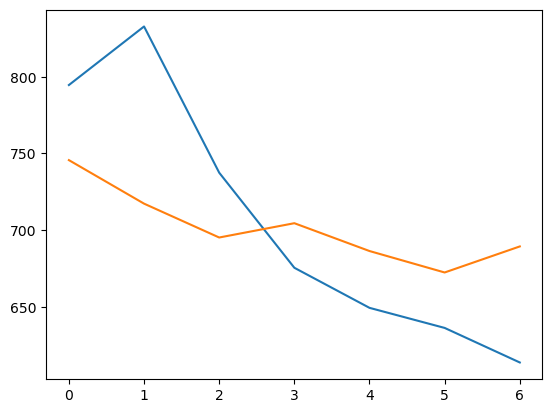

17:21:55 - cmdstanpy - INFO - Chain [1] start processing


MAE : 54.994
RMSE : 61.896
MAPE: 0.077
==================================== Prophet lang_ja =======================================


17:21:55 - cmdstanpy - INFO - Chain [1] done processing


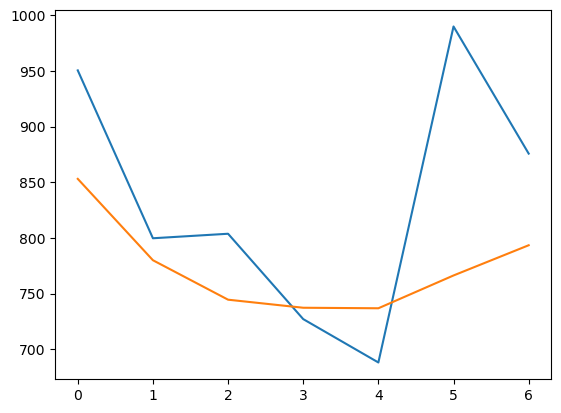

17:21:55 - cmdstanpy - INFO - Chain [1] start processing


MAE : 77.312
RMSE : 101.868
MAPE: 0.087
==================================== Prophet lang_zh =======================================


17:21:56 - cmdstanpy - INFO - Chain [1] done processing


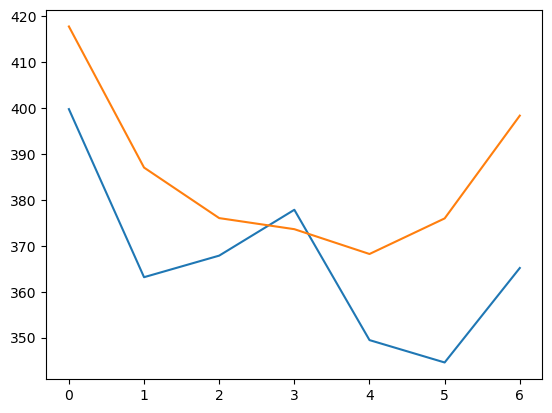

17:21:56 - cmdstanpy - INFO - Chain [1] start processing


MAE : 19.675
RMSE : 22.113
MAPE: 0.054
==================================== Prophet lang_ru =======================================


17:21:57 - cmdstanpy - INFO - Chain [1] done processing


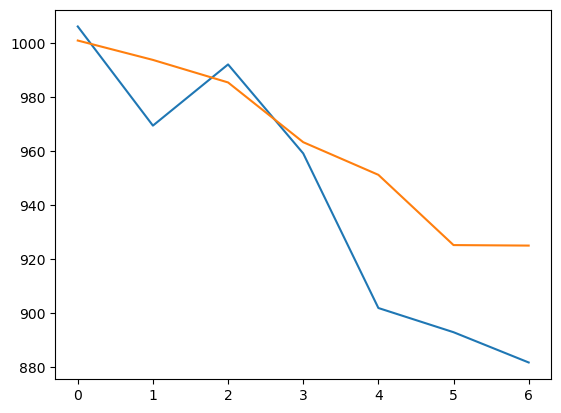

MAE : 23.64
RMSE : 29.39
MAPE: 0.026


In [ ]:
for i in lst_lang_data:
    print('==================================== Prophet',list(i.keys())[0],'=======================================')
    fb_prophet(list(i.values())[0])

## Pipeline for all models

In [ ]:
def pipeline(ts,exog=None):
    print('==================================== ARIMA =======================================')
    arima(ts,pdq)
    print('==================================== SARIMAX =======================================')
    sarimax(ts,pdq,pdqs,exog=exog)
    print('==================================== FBPROPHET =======================================')
    fb_prophet(ts)

==================================== ARIMA =======================================


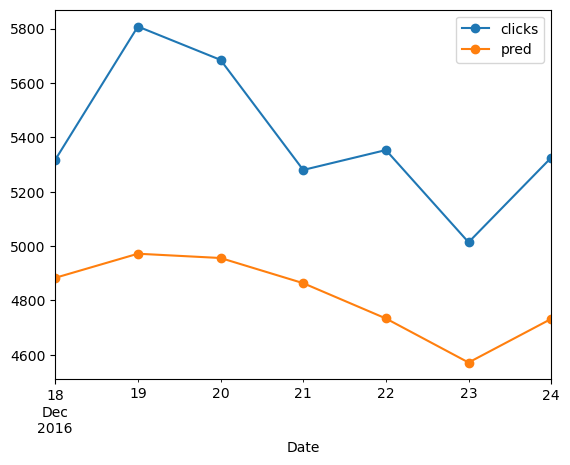

MAE : 581.614
RMSE : 600.506
MAPE: 0.107
==================================== SARIMAX =======================================


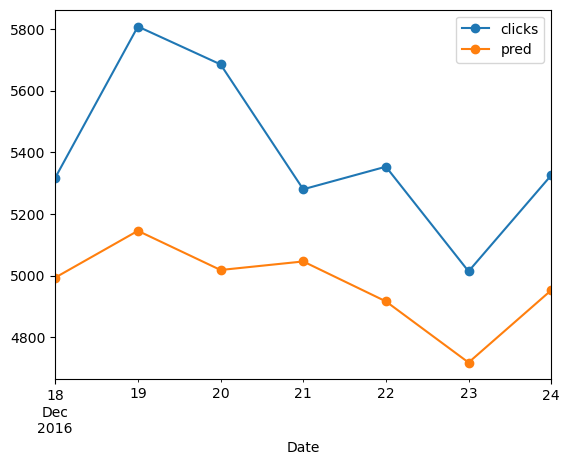

17:42:32 - cmdstanpy - INFO - Chain [1] start processing


MAE : 427.477
RMSE : 456.737
MAPE: 0.078
==================================== FBPROPHET =======================================


17:42:32 - cmdstanpy - INFO - Chain [1] done processing


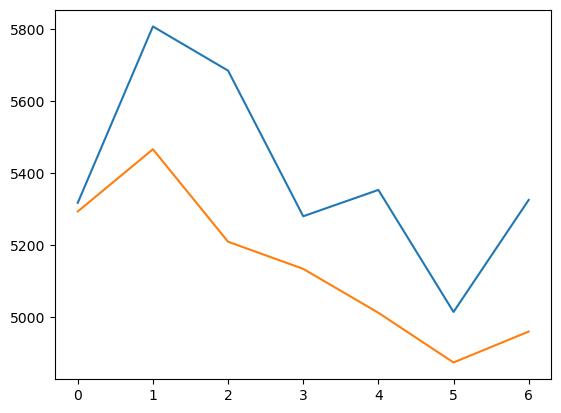

MAE : 262.265
RMSE : 301.299
MAPE: 0.048


In [ ]:
pipeline(lang_en)

## Questionnaire:

**1. Defining the problem statements and where can this and modifications of this be used?**

- Understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients.

- This can be used to place ads of relevent products in the related search pages so that the clicks can increase and make more profits with less cost in ads.

**2. Write 3 inferences you made from the data visualizations**

- language es is may have 6 months seasonality.
- campaign is more effective for language en and ru as there is a spike at 7-8 months.
- language en is having more views compare to other languages.
- Monday there are more views compare to other days.

**3. What does the decomposition of series do?**

- It deconstructs a time series into several components, each representing one of the underlying categories of patterns. For example every time series can be divided into trend, seasonality, residuals components.

**4. What level of differencing gave you a stationary series?**

- At first level of differencing (de-trending) we got stationary series for all languages.

**5. Difference between arima, sarima & sarimax.**

- ARIMA doesn't use seasonality and exog variable.
- SARIMA uses seasonality and not uses exog variable.
- SARIMAX uses both seasonality and exog variable

**6. Compare the number of views in different languages**

<AxesSubplot:>

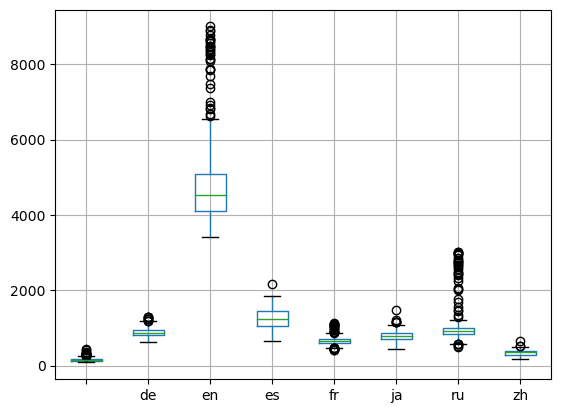

In [185]:
clean_data.boxplot()

- language en is having high view count of pages.

**7. What other methods other than grid search would be suitable to get the model for all languages?**

- Randomized search, Hyperopt, Bayesian optimization.

## Results:

- Got minimum MAPE of 2.3% for language zh using ARIMA.
- Got minimum MAPE range in 2.6% to 7.6% for all languages in different models.